<a href="https://colab.research.google.com/github/davidolima/car-model-classification/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final - Curso Deep Learning
### Prof. Luciano de Rebouças
### Aluno: David de Oliveira Lima

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
# !kaggle datasets download -d peterjun/car196 -p "/content/drive/MyDrive/Colab Notebooks"
# %cd "/content/drive/MyDrive/Colab Notebooks"
# !unzip car196.zip
# !rm car196.zip

In [3]:
# Core
import tensorflow as tf
import tensorflow.keras as keras

# Redes e optimizers
from keras.applications import VGG19, ResNet50V2, EfficientNetB0, InceptionV3
from keras.optimizers import Adam, SGD

# Keras
from keras import Sequential
from keras.utils import to_categorical, image_dataset_from_directory, split_dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K


# Etc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow_datasets as tfds
import scipy.io
# import deeplake

# Parâmetros

In [4]:
n_classes = 196
epochs = 50
batch_size = 64
n_splits = 5
img_size = (224,224)
es_patience = 8
root = "/content/drive/MyDrive/Colab Notebooks/car196/"
val_split = 0.2
channels = 3

# Inicialização

In [17]:
def plothist(hist):
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['val_precision_m'])
    plt.plot(hist.history['val_recall_m'])
    plt.plot(hist.history['val_f1_m'])
    plt.title('Several Metrics')
    plt.ylabel('metrics')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'Precision', 'Recall', 'F1_score'], loc='lower right')
    plt.show()

# Métricas

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Data

In [7]:
# Carregando dataset
ds_train, ds_val = image_dataset_from_directory(
    root + "train/",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    seed=2023,
    validation_split=val_split,
    subset='both',
    image_size=img_size,
    shuffle=True,
)

print("Test images")
ds_test = image_dataset_from_directory(
    root + "test/",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    seed=2023,
    image_size=img_size,
    shuffle=True,
)

# ds_train, ds_val = split_dataset(ds_train, left_size=1-val_split, right_size=val_split)
#print(ds_train.,"training images")
# print(len(ds_val),"validation images")
# print(len(ds_test),"testing images")

Found 8144 files belonging to 196 classes.
Using 6516 files for training.
Using 1628 files for validation.
Test images
Found 8041 files belonging to 196 classes.


In [8]:
# Augmentation
resize_and_rescale = tf.keras.Sequential([
  Resizing(img_size[0], img_size[1]),
  Rescaling(1./255)
])

augmentation = keras.Sequential([
    # Resizing(img_size[0],img_size[1]),
    # Rescaling(1./255),
    RandomRotation(0.30),
    RandomFlip("horizontal"),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Treinamento das redes

## VGG19

In [9]:
adam = Adam(.001,
           beta_1=0.9,
           beta_2=0.999,
           )

sgd = SGD(
    5e-3,
    momentum=.9
)
criterion = categorical_crossentropy
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min', verbose=1,
                           patience=es_patience,
                           restore_best_weights = True
                           )

In [14]:
base = VGG19(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

for l in base.layers:
  l.trainable = False
model_1 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    # Dense(2048,activation='relu'),
    # Dropout(.2),
    # Dense(2048, activation='relu'),
    # Dropout(.2),
    # Dense(1024, activation='relu'),
    Dense(n_classes, activation='softmax'),
])
model_1.build((None, img_size[0], img_size[1], channels))
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 196)               4917444   
                                                                 
Total params: 24,941,828
Trainable params: 4,917,444
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
# Training
checkpoint = ModelCheckpoint(f"/content/trab-final-best-vgg.hdf5",
                            monitor='loss', verbose=1,
                            save_best_only=True,
                            mode='auto')

model_1.compile(loss=criterion,
            optimizer=sgd,
            metrics=["accuracy",
                     recall_m,
                     precision_m,
                     f1_m],
            )

history = model_1.fit(ds_train,
                  validation_data=ds_val,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  callbacks=[keras.callbacks.History(), early_stop, checkpoint])

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 7.2779 - accuracy: 0.0098 - recall_m: 1.5319e-04 - precision_m: 0.0016 - f1_m: 2.8011e-04
Epoch 1: loss improved from inf to 7.27793, saving model to /content/trab-final-best-vgg.hdf5
102/102 [==============================] - 53s 497ms/step - loss: 7.2779 - accuracy: 0.0098 - recall_m: 1.5319e-04 - precision_m: 0.0016 - f1_m: 2.8011e-04 - val_loss: 8.2746 - val_accuracy: 0.0190 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
102/102 [==============================] - ETA: 0s - loss: 7.3016 - accuracy: 0.0226 - recall_m: 4.5956e-04 - precision_m: 0.0229 - f1_m: 8.9597e-04
Epoch 2: loss did not improve from 7.27793
102/102 [==============================] - 48s 445ms/step - loss: 7.3016 - accuracy: 0.0226 - recall_m: 4.5956e-04 - precision_m: 0.0229 - f1_m: 8.9597e-04 - val_loss: 7.4305 - val_accuracy: 0.0405 - val_recall_m: 0.0012 - val_precision_m: 0.0769 - val_f1_m: 0.0024

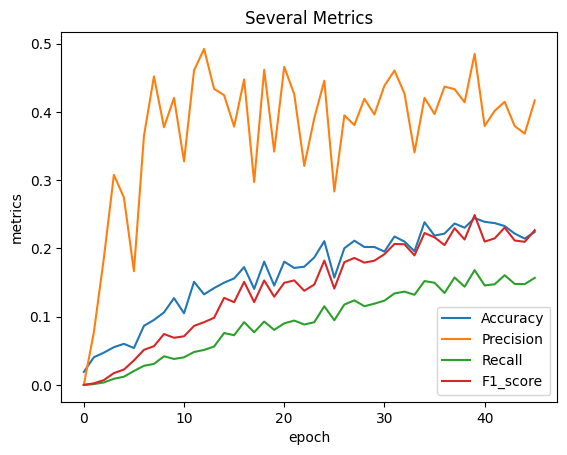

In [18]:
plothist(history)

In [20]:
model_test_acc=model_1.evaluate(ds_test,batch_size=64)

126/126 [==============================] - 1125s 9s/step - loss: 4.4191 - accuracy: 0.2287 - recall_m: 0.1458 - precision_m: 0.4246 - f1_m: 0.2162


## EfficientNetB0

In [ ]:
base = EfficientNetB0(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

base.trainable = False
model_2 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.2),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(n_classes, activation='softmax'),
])

model_2.build((None, img_size[0], img_size[1], channels))
model_2.summary()

In [ ]:
# Training
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Colab Notebooks/trab-final-best-effnetb0.hdf5",
                            monitor='loss', verbose=1,
                            save_best_only=True,
                            mode='auto')

model_2.compile(loss=criterion,
            optimizer=sgd,
            metrics=["accuracy"],
            )

history = model_2.fit(ds_train,
                  validation_data=ds_val,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  callbacks=[keras.callbacks.History(), early_stop, checkpoint])

In [ ]:
plothist(history)

In [ ]:
model_test_acc=model_2.evaluate(ds_test,batch_size=4)

## ResNet50V2

In [ ]:
base = ResNet50V2(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

base.trainable = False
model_3 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.2),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(n_classes, activation='softmax'),
])

model_3.build((None, img_size[0], img_size[1], channels))
model_3.summary()

In [ ]:
# Training
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Colab Notebooks/trab-final-best-resnet50v2.hdf5",
                            monitor='loss', verbose=1,
                            save_best_only=True,
                            mode='auto')

model_3.compile(loss=criterion,
            optimizer=sgd,
            metrics=["accuracy"],
            )

history = model_3.fit(ds_train,
                  validation_data=ds_val,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  callbacks=[keras.callbacks.History(), early_stop, checkpoint])

In [ ]:
plothist(history)

In [ ]:
model_test_acc=model_3.evaluate(ds_test,batch_size=4)

## InceptionV3

In [ ]:
base = InceptionV3(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

base.trainable = False
model_4 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.2),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(n_classes, activation='softmax'),
])

model_4.build((None, img_size[0], img_size[1], channels))
model_4.summary()

In [ ]:
# Training
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Colab Notebooks/trab-final-best-inceptionv3.hdf5",
                            monitor='loss', verbose=1,
                            save_best_only=True,
                            mode='auto')

model_4.compile(loss=criterion,
            optimizer=sgd,
            metrics=["accuracy"],
            )

history = model_2.fit(ds_train,
                  validation_data=ds_val,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  callbacks=[keras.callbacks.History(), early_stop, checkpoint])

In [ ]:
plothist(history)

In [ ]:
model_test_acc=model_4.evaluate(ds_test,batch_size=4)

# K-fold Cross-validation

In [ ]:
k = 5

# Referências

[1] - [Choose an activation function for deep learning - Machine Learning Mastery](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)

[2] - [Data augmentation - Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation)
